#### Section 1: Import necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Section 2: Load and explore the dataset

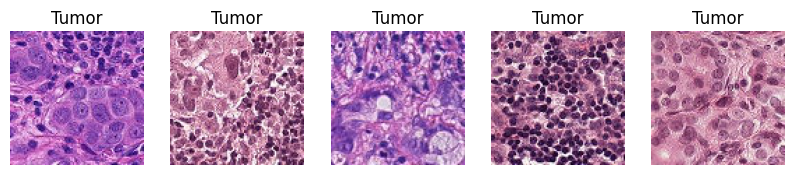

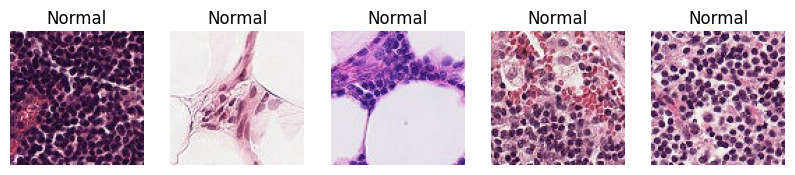

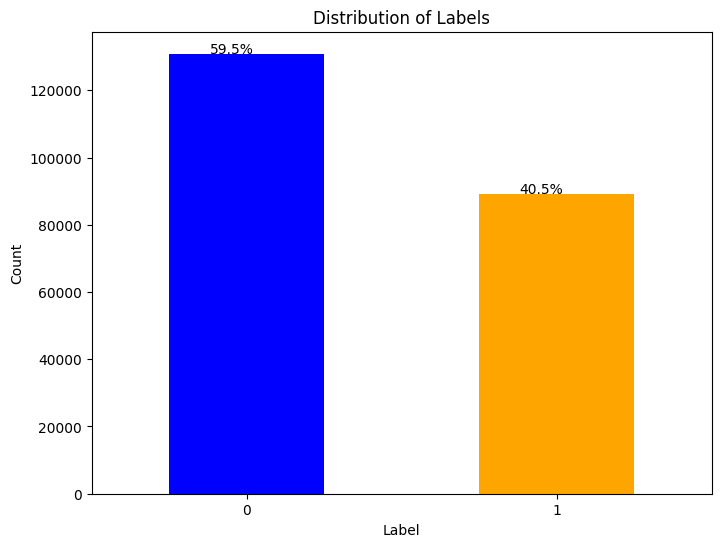

In [2]:
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'
train_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# EDA - Sample Tumor and Normal Images
def display_samples(sample_ids, title):
    images = [Image.open(os.path.join(train_path, id + '.tif')) for id in sample_ids]
    plt.figure(figsize=(10, 3))
    for i, img in enumerate(images):
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

sample_tumor_ids = train_data[train_data['label'] == 1]['id'].sample(n=5).values
sample_normal_ids = train_data[train_data['label'] == 0]['id'].sample(n=5).values

display_samples(sample_tumor_ids, 'Tumor')
display_samples(sample_normal_ids, 'Normal')

# Label Distribution
label_counts = train_data['label'].value_counts()
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
total = len(train_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + total * 0.001
    ax.annotate(percentage, (x, y), ha='center')
plt.show()


#### Section 3: Split the data into training and validation sets

In [3]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)


#### Section 4: Model architecture and Compilation

In [4]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Regularization: Dropout
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

#### Section 5: Data Preparation and Augmentation

In [5]:
# Add .tif extension to "id" column
train_data["id"] = train_data["id"].apply(lambda x: x + ".tif")
train_data["label"] = train_data["label"].astype(str)

# Subset of data for faster testing
train_data_subset = train_data.sample(frac=0.1, random_state=42)

# Data Generator
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2,
    horizontal_flip=True,  # Augmentation: Randomly flip images horizontally
    vertical_flip=True,    # Augmentation: Randomly flip images vertically
    rotation_range=30,     # Augmentation: Randomly rotate images by up to 30 degrees
    zoom_range=0.3,        # Augmentation: Randomly zoom into images
)

# Training Data Generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data_subset,  # Use the subset
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=64,
    seed=13,
    class_mode="binary",
    target_size=(64, 64),
    shuffle=True
)

# Validation Data Generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data_subset,  # Use the subset
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=64,
    seed=13,
    class_mode="binary",
    target_size=(64, 64),
    shuffle=True
)


Found 14082 validated image filenames belonging to 2 classes.
Found 3520 validated image filenames belonging to 2 classes.


#### Section 6: Model Training

In [6]:
epochs = 5  

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/5
221/221 [==============================] - 148s 651ms/step - loss: 0.5531 - accuracy: 0.7176 - val_loss: 0.5255 - val_accuracy: 0.7497
Epoch 2/5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 47s 211ms/step - loss: 0.5002 - accuracy: 0.7658 - val_loss: 0.4947 - val_accuracy: 0.7693
Epoch 3/5
221/221 [==============================] - 46s 207ms/step - loss: 0.4773 - accuracy: 0.7798 - val_loss: 0.4676 - val_accuracy: 0.7815
Epoch 4/5
221/221 [==============================] - 46s 208ms/step - loss: 0.4649 - accuracy: 0.7851 - val_loss: 0.4637 - val_accuracy: 0.7858
Epoch 5/5
221/221 [==============================] - 46s 209ms/step - loss: 0.4609 - accuracy: 0.7887 - val_loss: 0.4623 - val_accuracy: 0.7835


#### Section 7: Results and Analysis

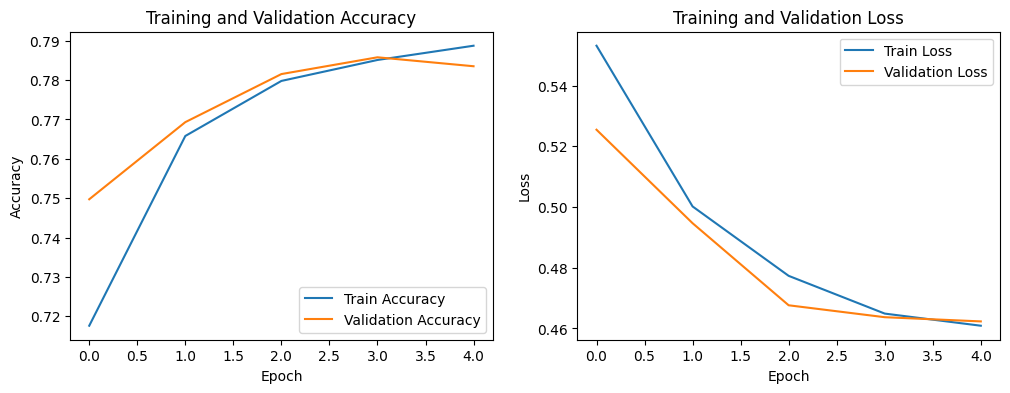

In [7]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)


#### Section 8: Create Submission File

In [8]:
test_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_data["id"] = test_data["id"].apply(lambda x: x + ".tif")

# Data Generator for Test Set
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col="id",
    y_col=None,
    class_mode=None,
    target_size=(64, 64),
    batch_size=64,
    shuffle=False
)

# Generate predictions
predictions = model.predict(test_generator)
test_data['label'] = (predictions >= 0.5).astype(int)

# Save the submission file
submission_path = '/kaggle/working/submission.csv'
test_data.to_csv(submission_path, columns=['id', 'label'], index=False)

# Display the head of the submission file
test_data.head()

Found 57458 validated image filenames.
898/898 [==============================] - 402s 448ms/step


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0
